# Robustness Testing
This notebook will further filter down our selected set of 50 policies. It does so by evaluating the robustness of each policy through two measures. Firstly, we examine the signal-to-noise ratio for each of the 50 policies. This 'SNR'-ratio is an indicator for how well the policy performs in different scenarios. Since we want to minimise each outcome of interest, lower SNR-ratio scores mean a more robust policy. Using these results, we will filter down from 50 to 20 policies, keeping the 20 policies with the best (lowest) SNR-ratio score.

Next, we compute the maximum regret for each of the remaining policies. This is a measure that compares a value for a certain outcome of one policy with the value of that outcome of the best performing policy for that specific outcome. At this stage, all remaining policies can be considered to be well performing, computing the maximum regret scores allows us to handpick a final set of four policies that are well performing on interesting combinations of outcomes for our stakeholder.

In [6]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from ema_workbench import (
    ScalarOutcome,
    load_results,
    Policy,
    MultiprocessingEvaluator
)
from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging, utilities

from sklearn.preprocessing import MinMaxScaler

from custom_problem_formulation_no_RfR import get_model_for_problem_formulation

In [7]:
# Load policies from the CSV file
policies_df = pd.read_csv('results/50_diverse_policies.csv')

# Drop unwanted columns
policies_df = policies_df.drop(columns=[
    'A.1_External Costs',
    'A.1_Expected Number of Deaths',
    'A.1_Expected Annual Damage',
    'A.2_External Costs',
    'A.2_Expected Number of Deaths',
    'A.2_Expected Annual Damage',
    'composite_ooi',
    'satisfied'
])

# Create a new column with the desired format
policies_df['index'] = 'scenario' + policies_df['scenario'].astype(str) + '_policy' + policies_df['Unnamed: 0'].astype(str)

# Set the new column as the index
policies_df.set_index('index', inplace=True)

# Drop the original 'scenario' and 'unnamed: 0' columns
policies_df = policies_df.drop(columns=['scenario', 'Unnamed: 0'])

policies_df


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
index,,,,,,,,,,,,,,,,,,,,,
scenario18563_policy7,0,1,0,0,1,0,1,1,1,1,...,0,2,6,4,1,5,0,9,6,6
scenario5666_policy110,0,0,0,1,0,0,1,1,1,1,...,0,1,7,2,3,6,4,5,2,6
scenario5666_policy88,1,0,0,1,0,0,1,1,1,1,...,0,1,2,0,1,6,3,0,3,6
scenario5666_policy102,0,0,1,0,1,0,1,1,1,1,...,0,5,5,4,6,3,5,6,10,3
scenario5666_policy100,0,0,0,0,0,0,1,1,1,1,...,0,0,4,3,2,0,5,7,3,2
scenario18563_policy13,0,0,0,0,0,0,1,1,1,1,...,0,3,5,2,1,7,7,6,6,6
scenario5666_policy81,0,0,0,0,1,0,1,1,1,1,...,0,5,2,2,2,3,6,6,4,6
scenario18563_policy16,0,0,0,0,1,0,1,1,1,1,...,0,3,3,4,0,6,2,6,6,7
scenario5666_policy66,0,0,0,0,1,1,1,1,1,1,...,0,1,7,4,4,7,6,5,7,0


In [3]:
# Create a list of the selected policies so they can be implemented in the experiments
policies = []
for idx, row in policies_df.iterrows():
    policy_dict = row.to_dict()
    policy_name = idx
    policies.append(Policy(policy_name, **policy_dict))

model, steps = get_model_for_problem_formulation()

# Define the number of scenarios
n_scenarios = 1000

# Perform experiments
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies)

experiments, outcomes = results

100%|████████████████████████████████████| 50000/50000 [45:58<00:00, 18.13it/s]


In [4]:
# Saving the results
utilities.save_results(results, 'results/50_policies_1000_scenarios.tar.gz')

In [8]:
# Load the results
results = utilities.load_results('results/50_policies_1000_scenarios.tar.gz')

experiments, outcomes = results

# Create a DataFrame with the outcomes and experiments
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
policies_50_results = outcomes.join(experiments)

In [9]:
# Function to calculate SNR metric
def calculate_snr(policy, direction):
  mean_performance = np.mean(policy)
  std_dev = np.std(policy)
  
  if direction == ScalarOutcome.MINIMIZE:
      snr = mean_performance * std_dev
  else:
      snr = mean_performance / std_dev
  return snr


In [10]:
# Initialize an empty list to store all SNR scores
snr_scores = []

# Iterate over each policy in the experiments DataFrame
for policy in experiments['policy'].unique():
    # Initialize a dictionary to store SNR scores for the current policy
    scores = {'policy': policy}
    
    # Filter experiments DataFrame to get rows where 'policy' matches the current policy
    logical = experiments['policy'] == policy
    
    # Iterate over each outcome in the model.outcomes list (replace with your actual outcomes)
    for outcome in model.outcomes:
        # Extract values from the experiments DataFrame where the logical condition is True
        value = outcomes[outcome.name][logical]
        
        # Calculate the signal-to-noise ratio (SNR) for the extracted values
        sn_ratio = calculate_snr(value, outcome.kind)
        
        # Store the SNR score in the scores dictionary with outcome name as key
        scores[outcome.name] = sn_ratio
    
    # Append the scores dictionary to the snr_scores list
    snr_scores.append(scores)

# Convert the list of dictionaries to a DataFrame
snr_scores_df = pd.DataFrame(snr_scores)

# Set policy column as
snr_scores_df.set_index('policy', inplace=True)

In [11]:
snr_scores_df

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
policy,,,,,,
scenario18563_policy7,0.0,0.000495,8.174137e+16,0.984149,9.636570e-08,8.204571e+12
scenario5666_policy110,0.0,0.000792,1.298678e+17,0.000000,3.951142e-07,3.501549e+13
scenario5666_policy68,0.0,0.000319,5.298790e+16,0.000000,1.684914e-06,1.554315e+14
scenario5666_policy102,0.0,0.000364,6.012097e+16,0.000000,4.067744e-07,3.600425e+13
scenario5666_policy100,0.0,0.000710,1.065576e+17,0.000000,1.740321e-08,1.391227e+12
scenario18563_policy13,0.0,0.003072,4.737514e+17,0.000000,3.352269e-07,3.017077e+13
scenario5666_policy81,0.0,0.000463,7.603008e+16,0.000000,1.666221e-06,1.539776e+14
scenario18563_policy14,0.0,0.001629,2.734662e+17,0.000000,3.609792e-07,3.238558e+13
scenario18563_policy12,0.0,0.002065,3.460318e+17,0.000000,3.474663e-07,3.127944e+13


It makes sense that for both A.1_External Costs and A.2_External Costs the snr ratio is 0 most of the times. This is due to the fact that we defined 'External Costs' as the sum of dike investment costs and evacuation costs. Both of these costs depend completely and mostly on policy levers respectively. Because the policy levers stay the same for all 1000 experiments that the policy is tested, it returns the same result every time, as a result of this the standard deviation is 0. Given the way the signal-to-noise ratio is calculated this will thus result in a value of 0 as well.

In [12]:
#Creating a composite snr score so we can select the 20 best policies, we value each outcome of interest equally

scaler = MinMaxScaler()
normalized_snr = scaler.fit_transform(snr_scores_df[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 'A.1_External Costs',
                                                   'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths', 'A.2_External Costs']])
composite_snr = normalized_snr.sum(axis=1)
snr_scores_df['composite_snr'] = composite_snr 

# Dropping the 30 worst policies based on composite_snr score
snr_scores_df_top_20 = snr_scores_df.drop(snr_scores_df['composite_snr'].nlargest(30).index)

In [13]:
snr_scores_df_top_20

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_snr
policy,,,,,,,
scenario5666_policy68,0.0,0.000319,5.298790e+16,0.0,1.684914e-06,1.554315e+14,0.377609
scenario5666_policy102,0.0,0.000364,6.012097e+16,0.0,4.067744e-07,3.600425e+13,0.251561
scenario5666_policy100,0.0,0.000710,1.065576e+17,0.0,1.740321e-08,1.391227e+12,0.420672
scenario5666_policy81,0.0,0.000463,7.603008e+16,0.0,1.666221e-06,1.539776e+14,0.473124
scenario5666_policy48,0.0,0.000605,9.911970e+16,0.0,3.987696e-07,3.526522e+13,0.415182
scenario5666_policy26,0.0,0.000509,8.366260e+16,0.0,4.009661e-07,3.543339e+13,0.350118
scenario5666_policy38,0.0,0.000416,6.859611e+16,0.0,1.679461e-06,1.549772e+14,0.443163
scenario5666_policy67,0.0,0.000291,4.905684e+16,0.0,1.687108e-06,1.556725e+14,0.359881
scenario5666_policy62,0.0,0.000416,6.859611e+16,0.0,4.072379e-07,3.604019e+13,0.287418


We are now left with a set of 20 policies. We will also plot a parallel axes plot to gain a quick insight into potential obvious tradeoffs or any dominated policies.

/var/folders/mz/j0q1_7_x2f59p13bv_c81xhc0000gn/T/ipykernel_47614/585867307.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(snr_scores_df_top_20.index.unique()))


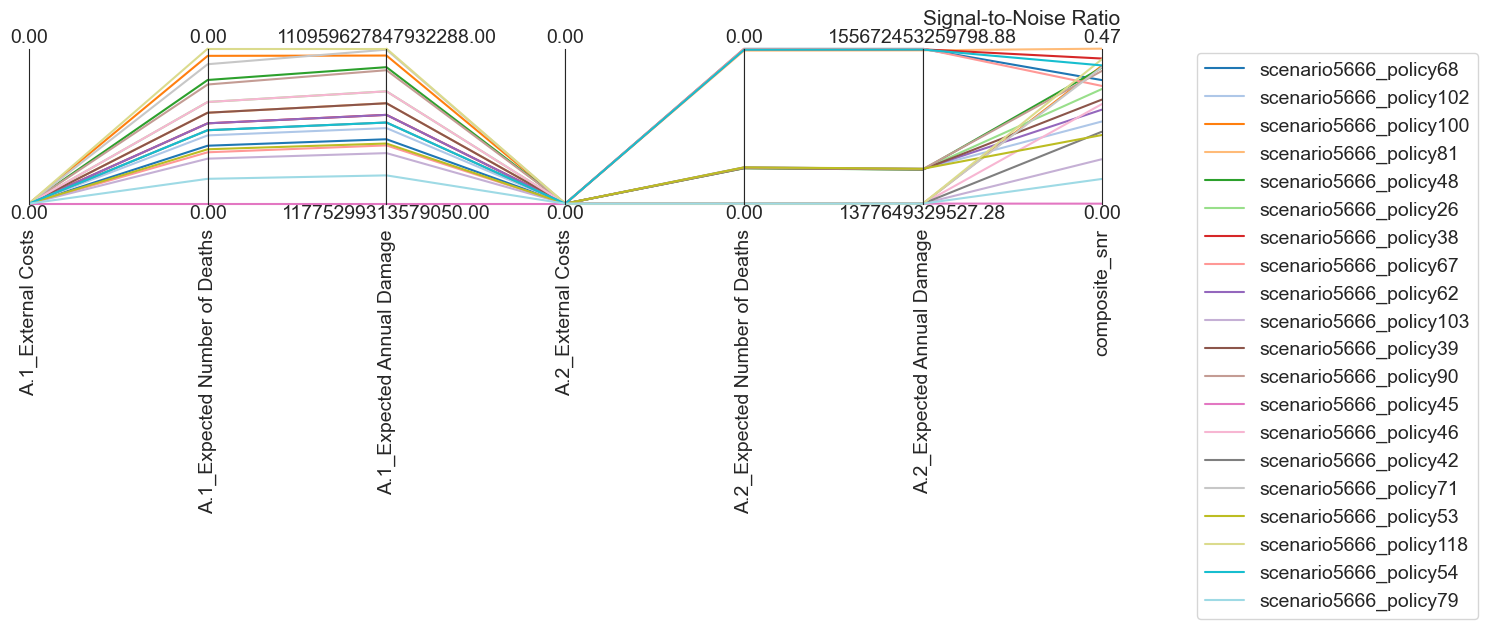

In [14]:
import matplotlib.cm as cm

# Create a colormap
cmap = cm.get_cmap('tab20', len(snr_scores_df_top_20.index.unique()))

# Get the limits for the plot
limits = parcoords.get_limits(snr_scores_df_top_20)

# Create a parallel axes plot
paraxes = parcoords.ParallelAxes(limits)

for i, policy in enumerate(snr_scores_df_top_20.index.unique()):
    data = pd.DataFrame(snr_scores_df_top_20.loc[policy]).transpose()
    paraxes.plot(data, color=cmap(i), label=policy)

paraxes.legend()
fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.title('Signal-to-Noise Ratio', loc='left', fontsize=15)
plt.savefig('images/snr_top20.png')
plt.show()

### Max Regret

In [16]:
# Define a function to extract the scenario_original
def extract_scenario(policy):
    return policy.split('_')[0][8:]

# Apply the function to create the new column
policies_50_results['scenario_original'] = policies_50_results['policy'].apply(lambda x: extract_scenario(x))

In [17]:
# Get unique values in 'policy' column
unique_scenarios = policies_50_results['scenario_original'].unique()
print("Unique scenarios:", unique_scenarios)

# Create a dictionary of DataFrames, each keyed by unique scenario value
scenario_dfs = {scenario: policies_50_results[policies_50_results['scenario_original'] == scenario] \
                .reset_index(drop=True) for scenario in unique_scenarios}

df_scenario_18563 = scenario_dfs['18563']
print("DataFrame for scenario 18563:")
display(df_scenario_18563.head())

# Do the same for the other scenarios
df_scenario_11066 = scenario_dfs['11066']
df_scenario_5666 = scenario_dfs['5666']

Unique scenarios: ['18563' '5666' '11066']
DataFrame for scenario 18563:


,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,scenario_original
0,0,0.129964,1.737482e+09,6.604510e+07,0.0,0.0,22,336.005982,1.0,0.058061,...,1,5,0,9,6,6,0,scenario18563_policy7,dikesnet,18563
1,0,0.000000,0.000000e+00,6.604510e+07,0.0,0.0,100,256.563550,1.0,0.560653,...,1,5,0,9,6,6,1,scenario18563_policy7,dikesnet,18563
2,0,0.000000,0.000000e+00,6.604510e+07,0.0,0.0,72,305.975903,1.0,0.405947,...,1,5,0,9,6,6,2,scenario18563_policy7,dikesnet,18563
3,0,0.000000,0.000000e+00,6.604510e+07,0.0,0.0,100,98.486572,1.5,0.489505,...,1,5,0,9,6,6,3,scenario18563_policy7,dikesnet,18563
4,0,0.000000,0.000000e+00,6.604510e+07,0.0,0.0,130,286.700503,10.0,0.490766,...,1,5,0,9,6,6,4,scenario18563_policy7,dikesnet,18563


In [18]:
# Define the outcomes of interest
outcomes_of_interest = ['A.1_External Costs',
 'A.1_Expected Number of Deaths',
 'A.1_Expected Annual Damage',
 'A.2_External Costs',
 'A.2_Expected Number of Deaths',
 'A.2_Expected Annual Damage'
 ]

# Create a list of all remaining policies
remaining_policies = snr_scores_df_top_20.index.unique().to_list()
print('Remaining policies: ', remaining_policies), print('len: ', len(remaining_policies))

# Create a set to store the unique scenario values
setje = set()
for item in remaining_policies:
    setje.add(item.split('_')[0])
print(setje)

Remaining policies:  ['scenario5666_policy68', 'scenario5666_policy102', 'scenario5666_policy100', 'scenario5666_policy81', 'scenario5666_policy48', 'scenario5666_policy26', 'scenario5666_policy38', 'scenario5666_policy67', 'scenario5666_policy62', 'scenario5666_policy103', 'scenario5666_policy39', 'scenario5666_policy90', 'scenario5666_policy45', 'scenario5666_policy46', 'scenario5666_policy42', 'scenario5666_policy71', 'scenario5666_policy53', 'scenario5666_policy118', 'scenario5666_policy54', 'scenario5666_policy79']
len:  20
{'scenario5666'}


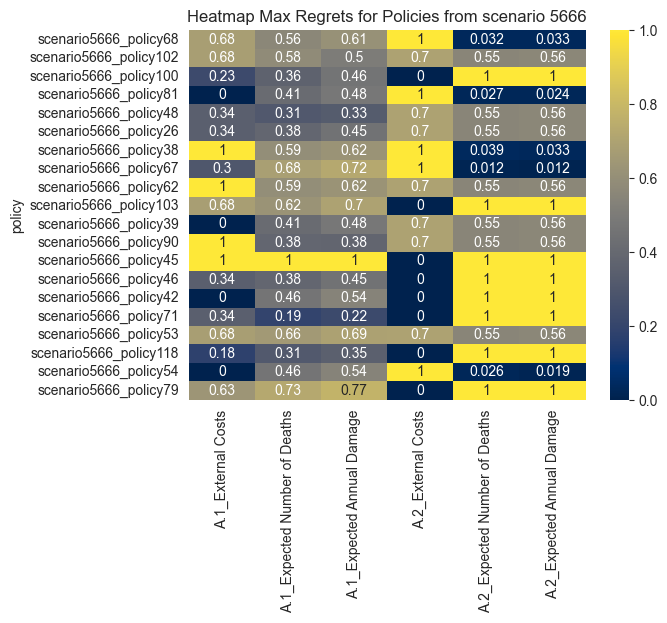

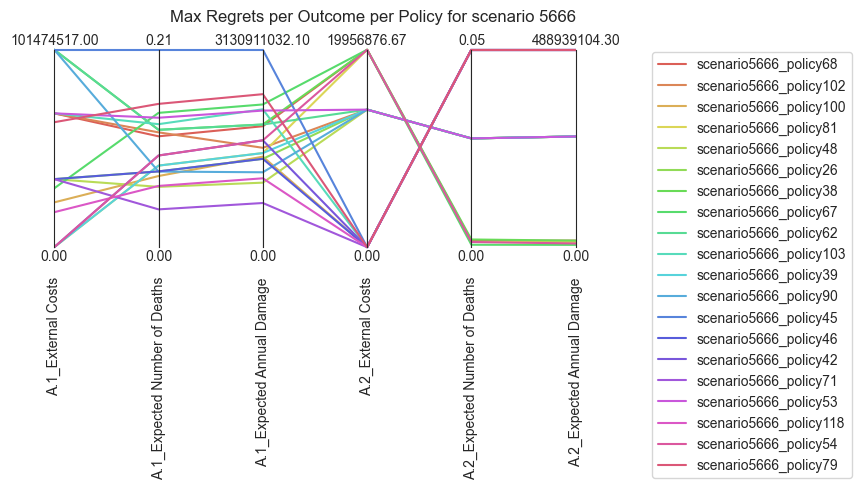

In [28]:
# List of all scenario's dataframes, based on the set of unique scenario values defined above
all_scenario_df = [df_scenario_5666] # only 1 original scenario with policies

# Loop over all scenarios df's
for df_scenario in all_scenario_df:
    
    # Create dictionaries to store the maximum regret for each outcome and all regrets
    max_regret = dict()
    all_regrets = dict()
    
    # Loop over all outcomes of interest
    for outcome in outcomes_of_interest:

        # Select the relevant data
        data = df_scenario[[outcome, 'policy', 'scenario']]

        # Only keep remaining policies as found by the snr analysis
        data = data[data['policy'].isin(remaining_policies)]
        
        # Reorient the data by indexing with policy and scenario id
        data = data.pivot(index='scenario', columns='policy')
       
        # Flatten the column index         
        data.columns = data.columns.get_level_values(1)
        
        # Calculate the regret for each outcome
        outcome_regret = np.abs(data.sub(data.max(axis=1), axis=0))

        # Store the regret values in the dictionaries    
        all_regrets[outcome] = outcome_regret
        max_regret[outcome] = outcome_regret.max()

    # max_regret in a DataFrame
    max_regret = pd.DataFrame(data=max_regret)

    # Normalize the max_regret
    normalized_max_regret = max_regret/max_regret.max()

    # Save the scenario string for the title
    scenario_string = str(df_scenario['scenario_original'][0])

    # Plot the heatmap
    sns.heatmap(normalized_max_regret, cmap='cividis', annot=True)
    plt.title(f'Heatmap Max Regrets for Policies from scenario {scenario_string}')
    plt.savefig('images/regret_' + scenario_string + '_heatmap.png')
    plt.show()

    # Data for the parallel plot (not normalized)
    data = max_regret

    # Get the limits for the parallel plot
    limits = parcoords.get_limits(data)
    # Set first row to 0, so we can see the lines better
    limits.loc[0, :] = 0
    
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette('hls', data.shape[0])
        temp_df = pd.DataFrame(row).transpose()
        paraxes.plot(temp_df, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Max Regrets per Outcome per Policy for scenario {scenario_string}', loc='right')
    plt.savefig('images/max_regret_' + scenario_string + '_parallel_plot.png')
        
    plt.show()

In [181]:
snr_scores_df_top_20.sort_values(by='composite_snr', ascending=True).head()

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_snr
policy,,,,,,,
scenario5666_policy45,0.0,0.000067,1.177530e+16,0.0,1.795543e-08,1.429173e+12,0.001660
scenario5666_policy79,0.0,0.000175,2.986806e+16,0.0,1.775784e-08,1.414118e+12,0.076748
scenario5666_policy103,0.0,0.000263,4.411498e+16,0.0,1.775804e-08,1.414125e+12,0.136774
scenario5666_policy53,0.0,0.000304,5.026147e+16,0.0,4.085288e-07,3.615452e+13,0.210341
scenario5666_policy42,0.0,0.000387,6.370315e+16,0.0,1.748014e-08,1.395173e+12,0.220303


Based on the 'SNR'-ratio scores and the maximum regret scores, we now handpick four remaining policies that we will recommend to our stakeholder. These are the following:

- 'scenario5666_policy45', we pick this because it has the lowest composite_snr score of all the remaining policies. Indicating that it will likely work best in the highest number of different scenarios.

- 'scenario5666_policy79', we pick this because it has the second lowest composite_snr score of all the remaining policies. It will thus also perform well in a high amount of different scenarios, presumably also performing well in scenarios in which policy 45 doesn't perform well and vice versa.

- 'scenario5666_policy71', we pick this because it has the lowest maximum regrest scores for 'A_1 Expected number of Deaths' and 'A_1 Expected Annual Damage', meaning that for the scenarios it was tested for, this was the most beneficial policy for minimising these two outcomes of interest.  

- 'scenario5666_policy67', we pick this because it has the lowest maximum regrest scores for 'A_2 Expected number of Deaths' and 'A_2 Expected Annual Damage', meaning that for the scenarios it was tested for, this was the most beneficial policy for minimising these two outcomes of interest. 


In [19]:
policies_to_keep = ['scenario5666_policy45', 'scenario5666_policy79', 'scenario5666_policy71', 'scenario5666_policy67']
policies_to_keep

['scenario5666_policy45',
 'scenario5666_policy79',
 'scenario5666_policy71',
 'scenario5666_policy67']

In [20]:
# Creating a csv file containing the final chosen policies and their levers

interested_levers = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'
]

final_policies = policies_to_keep.copy()
levers_dict = dict()
for policy in final_policies:
    
    levers = experiments[experiments['policy'] == policy].iloc[0].to_dict()
    levers_dict[policy] = levers
df_interested_levers_final_policies = pd.DataFrame(data=levers_dict).transpose()[interested_levers]
df_interested_levers_final_policies.to_csv('results/levers_final_policies.csv') # Save the levers to a csv file
df_interested_levers_final_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
scenario5666_policy45,1,1,0,1,0,0,1,1,1,1,...,0,6,7,2,7,7,6,4,4,7
scenario5666_policy79,0,0,0,1,1,0,1,1,1,1,...,0,2,1,7,3,7,6,1,7,5
scenario5666_policy71,1,0,0,0,0,0,1,1,1,1,...,0,6,2,2,1,1,0,7,4,5
scenario5666_policy67,0,1,0,0,0,0,1,1,1,1,...,0,5,3,0,2,3,6,4,5,6
